## Atividade Prática 4: Compressão usando DCT


### Nome: Diogo José Costa Alves 

### N° USP: 13709881.

###  Revisão

A DCT foi definida na seção 3.4 a partir de uma adaptação da transformada de Fourier: um vetor $x=\overrightarrow{x}\in\mathbb{R}^N$ era duplicado de forma espelhada $\tilde{x}=(\overrightarrow{x},\overleftarrow{x})$ e as redundâncias encontradas na transformada de Fourier $\tilde{X}\in\mathbb{C}^{2N}$ eram exploradas para recodificá-la na forma de um vetor $C=\mbox{DCT}(x)\in\mathbb{R}^N$:
\begin{align*}
	C_0 &= \sqrt{\frac{1}{N}}\sum\limits_{m=0}^{N-1} x_m \\
	C_k &= \sqrt{\frac{2}{N}}\sum\limits_{m=0}^{N-1} x_m\cos\left(\frac{\pi k\left(m+\frac{1}{2}\right)}{N}\right), k = 1, 2, \dots, N-1,\\
\end{align*}

cuja transformada inversa ($x=IDCT(C)$) é

\begin{equation*}
	x_m = \sqrt{\frac{1}{N}}C_0 + \sqrt{\frac{2}{N}}\sum\limits_{k=1}^{N-1}C_k\cos\left(\frac{\pi\left(m + \frac{1}{2}\right)k}{N}\right),\ m=0,1,\ldots,N-1.
\end{equation*}

Vimos também o esquema simples de compressão por limiarização da seção 3.3, que pode ser aplicado tanto à FFT quanto à DCT: dado $x\in\mathbb{R}^N$ e um parâmetro de limiarização $c\in[0,1]$, faça:

> Compressão/Descompressão(x):
>
>> $\mbox{compute}\ C=DCT(x)$
>>
>> $\mbox{calcule}\ M=\max\{|C_k|,\ k=0,\ldots,N-1\}$
>>
>> $\mbox{defina}\ \tilde{C}\in\mathbb{R}^N\ \mbox{como}$    
$$\tilde{C}_k = \left\{\begin{array}{ll}
    C_k&\mbox{se}\ |C_k|\ge cM,\\
    0&\mbox{c.c.}\end{array}\right.$$
>>
>> $\mbox{calcule o sinal reconstruído como}\ \tilde{x} = IDCT(\tilde{C})$
>>
>> $\mbox{calcule a razão de compressão como}\ P(c) = \frac{\#\{k\mid|C_k|\ge cM\}}{N}$
>>
>> $\mbox{calcule a distorção como}\ D(c) = \frac{\|x-\tilde{x}\|^2}{\|x\|^2}$
>>
>> 

O código a seguir usa a DCT (rápida) da SciPy e a compressão por limiarização da DCT em um exemplo de sinal simples com descontinuidade, usando $c=0.1$, e também mostra como a distorção se relaciona com a razão de compressão nesse sinal:

In [1]:
# importa dependências
import math as m
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dct, idct

# realiza compressão/descompressão de x com parâmetro de limiarização c e devolve x~, Dc e Pc
def CompDescomp(x,c):
    # calcula DCT e faz compressão por limiarização
    C = dct(x, norm='ortho')
    cM =  c * np.max(abs(C)) # limiar de compressão
    CC = C*(abs(C)>=cM) # DCT comprimida

    xtil = idct(CC, norm='ortho') # sinal reconstruído
    
    Pc = sum(abs(C)>=cM)/x.size # razão de compressão (proporção de coeficientes mantidos)
    if np.linalg.norm(x)**2>0:
        Dc = np.linalg.norm(x-xtil)**2/np.linalg.norm(x)**2 # distorção relativa
    else:
        Dc = np.linalg.norm(x-xtil)**2 # calcula distorção absoluta se sinal é nulo
    return xtil,Pc,Dc

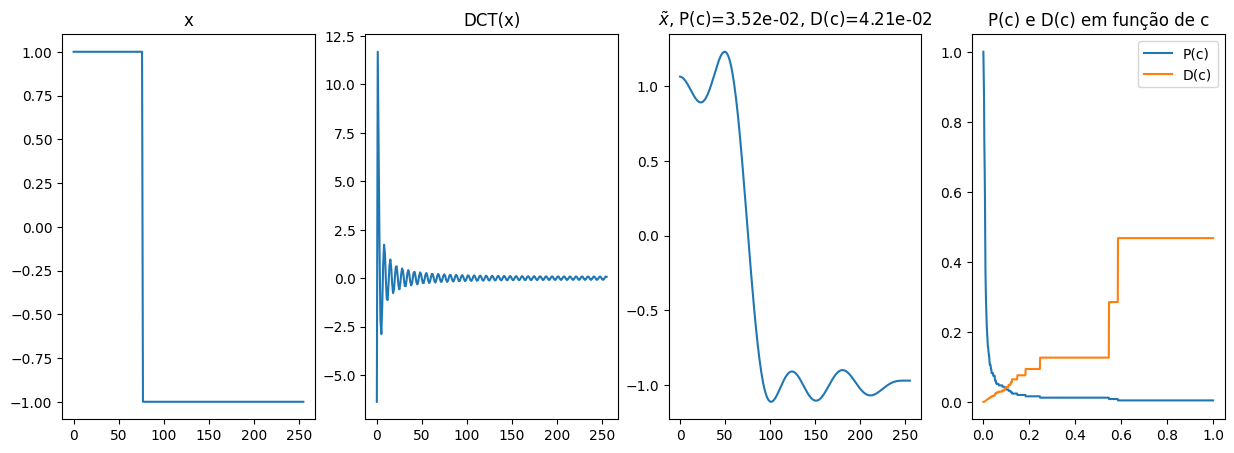

In [2]:
# gera sinal descontínuo com 30% de +1 e o restante -1, no intervalo [0,256)
N=256;
M=0.3;
x = -1+2*(np.array(range(N))<M*N);

# realiza compressão/descompressão com c=0.1
xtil,Pc,Dc = CompDescomp(x,0.1)

# gera gráficos de x, DCT(x) e x_til
fig, ax = plt.subplots(1,4,figsize=(15,5))
ax[0].set_title(r'x');
ax[0].plot(x)

ax[1].set_title(r'DCT(x)');
ax[1].plot(dct(x, norm='ortho'))

ax[2].set_title(r'$\tilde{{x}}$, P(c)={0:.2e}, D(c)={1:.2e}'.format(Pc,Dc));
ax[2].plot(xtil)

# gera gráficos de P(c) e D(c) usando a função CompDescomp
eps = 1e-3
c = np.arange(0,1+eps,eps)
Pc = np.zeros(len(c))
Dc = np.zeros(len(c))
for i in range(len(c)):
    dummy,Pc[i],Dc[i] = CompDescomp(x,c[i])
    
ax[3].set_title(r'P(c) e D(c) em função de c');
ax[3].plot(c,Pc,label='P(c)');
ax[3].plot(c,Dc,label='D(c)');
plt.legend();
plt.show();

---

**Exercício 1:** 

**(a)** Escreva uma função <tt>c_ótimo(x,d)</tt> que encontra um limiar ótimo $c^*$ em função da distorção máxima $d$ admissível na compressão do sinal x. Para isso, seu código deve buscar o maior valor de $c$ (aquele que corta mais coeficientes da DCT) que satisfaz $D(c)\le d$. Sua solução $c^*$ deve possuir acurácia de $\varepsilon=0.001$ (estar a no máximo $\varepsilon$ de distância do ótimo verdadeiro).

**Dica:** você pode fazer isso tanto por busca simples (percorrendo valores de $c$ de $\varepsilon$ em $\varepsilon$) quanto por busca binária (subdividindo o intervalo $[c_0,c_1]$ ao meio mantendo a propriedade $D(c_0)\le d$ e $D(c_1)>d$). Certifique-se de que o $c^*$ devolvido de fato satisfaz $D(c^*)\le d$: no caso da busca simples ascendente talvez você tenha que devolver o *penúltimo* valor de $c$ testado, e no caso da busca binária o melhor é devolver a extremidade *inferior* (e não o ponto médio) do último intervalo testado.

**Dica 2:** Se quiser utilizar o método da busca binária, pode valer a pena olhar o [método da bisseção](https://www.ufrgs.br/reamat/CalculoNumerico/livro-py/sdeduv-metodo_da_bissecao.html).

**(b)** Use sua função para plotar o limiar ótimo $c^*$ como função de $d$, para $d\in[0,1]$.

**Dica:** esse gráfico deve ser bem parecido com o gráfico de $D(c)$ acima, porém transposto.

In [3]:
# Resposta do exercício 1a
def c_otimo_linear(x, d):
    N = len(x)
    eps = 1e-3
    
    Cs = []
    Ps = []
    Ds = []
    
    cur_c = 0.0
    cur_p = 0.0
    cur_d = 0.0
    
    while cur_c < 1.0 and cur_d < d:
        cur_c += eps
        
        lixo, cur_p, cur_d = CompDescomp(x, cur_c)
        
        Cs.append(cur_c)
        Ps.append(cur_p)
        Ds.append(cur_d)
        
        
        
    return cur_c

c_otimo_linear(x,0.0)

0.0

In [13]:
def c_otimo_linear2(x, target_d):
    N = len(x)
    eps = 1e-3
    c_min = 0.0
    c_max = 1.0
    c_candidates = np.arange(c_min, c_max, eps)
    
    pointer = 0
    
    c_found = 0.0
    
    
    while pointer < len(c_candidates):
        cur_c = c_candidates[pointer]
        lixo, cur_p, cur_d = CompDescomp(x, cur_c)
        if(cur_d < target_d):
            c_found = cur_c
            pointer += 1
        else:
            break
            
            
    return c_found
        
c_otimo_linear2(x,0.3)

0.585

In [14]:
# tentando utilzar busca binária
def c_otimo_binario(x, target_d, verbose=False):
    N = len(x)

    eps = 1e-3
    c_min = 0.0
    c_max = 1.0
    c_candidates = np.arange(c_min, c_max, eps)
    
    min_pointer = 0
    max_pointer = len(c_candidates) - 1
    
    last_guess = -1
    while min_pointer < max_pointer:
        guess_pointer = min_pointer + (max_pointer-min_pointer)//2 
        
        if guess_pointer == last_guess:
            break
        else:
            last_guess = guess_pointer
            
        cur_c = c_candidates[guess_pointer]
        
        lixo, guess_p, guess_d = CompDescomp(x, cur_c)
        
        if verbose:
            print(f'min_pointer={min_pointer} max_pointer={max_pointer} guess_pointer={guess_pointer} cur_c={cur_c} guess_d={guess_d} targed_d={target_d}')

        if guess_d >= target_d:
            max_pointer = guess_pointer
        else:
            min_pointer = guess_pointer
            
        
    return cur_c

c_otimo_binario(x, 0.3, verbose=True)

min_pointer=0 max_pointer=999 guess_pointer=499 cur_c=0.499 guess_d=0.12611342803997683 targed_d=0.3
min_pointer=499 max_pointer=999 guess_pointer=749 cur_c=0.749 guess_d=0.4675781627526617 targed_d=0.3
min_pointer=499 max_pointer=749 guess_pointer=624 cur_c=0.624 guess_d=0.4675781627526617 targed_d=0.3
min_pointer=499 max_pointer=624 guess_pointer=561 cur_c=0.561 guess_d=0.2848658694462268 targed_d=0.3
min_pointer=561 max_pointer=624 guess_pointer=592 cur_c=0.592 guess_d=0.4675781627526617 targed_d=0.3
min_pointer=561 max_pointer=592 guess_pointer=576 cur_c=0.5760000000000001 guess_d=0.2848658694462268 targed_d=0.3
min_pointer=576 max_pointer=592 guess_pointer=584 cur_c=0.584 guess_d=0.2848658694462268 targed_d=0.3
min_pointer=584 max_pointer=592 guess_pointer=588 cur_c=0.588 guess_d=0.4675781627526617 targed_d=0.3
min_pointer=584 max_pointer=588 guess_pointer=586 cur_c=0.586 guess_d=0.4675781627526617 targed_d=0.3
min_pointer=584 max_pointer=586 guess_pointer=585 cur_c=0.585 guess_d=

0.585

In [22]:
def compare_c_otimos(x):
    eps = 0.005
    
    D_maximos = np.arange(0,1,eps)
    
    for d_maximo in D_maximos:
        print(f'd={d_maximo}', end='\r')
        c1 = c_otimo_linear2(x, d_maximo)
        c2 = c_otimo_binario(x, d_maximo)
        
        np.isclose(c1,c2) == True , f'Diferente d={d_maximo} \nlinear={c1} \tbinario={c2}'
    print('\nPassou')
        
compare_c_otimos(x)

KeyboardInterrupt: 

In [15]:
# Resposta do exercício 1b
# Use sua função para plotar o limiar ótimo 𝑐∗ como função de 𝑑, para 𝑑∈[0,1].
def plot_otimo_por_d(x):
    eps = 0.005
    
    D_maximos = np.arange(0,1,eps)
    C_otimos = []
    
    cur_otimo = 0.0
    
    for d_maximo in D_maximos:
        cur_otimo = c_otimo_linear2(x, d_maximo)
        C_otimos.append (cur_otimo)
        

    plt.plot(D_maximos, C_otimos, label='c*')
    
        
plot_otimo_por_d(x)

KeyboardInterrupt: 

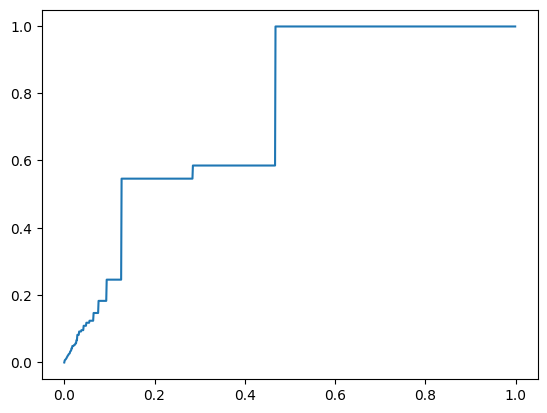

In [16]:
# Resposta do exercício 1b
# Use sua função para plotar o limiar ótimo 𝑐∗ como função de 𝑑, para 𝑑∈[0,1].
def plot_otimo_por_d(x):
    eps = 1e-3
    
    D_maximos = np.arange(0,1,eps)
    C_otimos = []
    
    cur_otimo = 0.0
    
    for d_maximo in D_maximos:
        cur_otimo = c_otimo_binario(x, d_maximo)
        C_otimos.append (cur_otimo)
        

    plt.plot(D_maximos, C_otimos, label='c*')
    
        
plot_otimo_por_d(x)

### Melhorando o resultado da compressão

O exemplo do pulso retangular é interessante por duas razões: ele traz a descontinuidade no interior do intervalo, o que representa um problema tanto para a DFT quanto para a DCT, mas ele também ilustra a melhor eficiência da DCT por eliminar a "descontinuidade da borda" (associada à repetição periódica do padrão implícita na DFT).

Uma forma de reduzir esse problema é aplicar uma estratégia segmentada para a compressão: se o sinal for segmentado em intervalos de tamanho $B$, apenas um desses intervalos conterá a descontinuidade em seu interior, e todos os demais intervalos devem ser muito mais fáceis de comprimir (pois são constantes no exemplo do pulso retangular). Em outras palavras, $x=(x_0,\ldots,x_{N-1})$ será dividido em segmentos
$$x^{(m)}=\left\{\begin{array}{ll}
(x_{m*B},\ldots,x_{(m+1)*B-1})& m=0,1,\ldots,\lfloor N/B\rfloor-1,\\
(x_{m*B},\ldots,x_{N-1})& m=\lfloor N/B\rfloor\quad\mbox{(apenas se $B$ não divide $N$)},\\
\end{array}\right.$$
e cada segmento $x^{(m)}$ é comprimido de forma independente, usando os melhores limiares possíveis.

**Exercício 2:** 

**(a)** Escreva uma função <tt>CompDescompSegm(x,B)</tt> que recorte o sinal $x$ em segmentos de tamanho $B$ e aplique a estratégia de compressão em cada segmento, escolhendo o limiar ótimo em cada um deles de forma a garantir uma distorção relativa menor que $\delta=10^{-8}$ em cada segmento. Sua função deve devolver o sinal reconstruído $\tilde{x}$, a taxa de compressão $P$ e a distorção relativa $D$. Você pode considerar que $B$ divide $N$, de tal forma que o número de segmentos será exatamente $\frac{N}{B}$.

**Dica:** A taxa de compressão pode ser computada como a média dos valores $P_1(c_1),P_2(c_2),\ldots,P_M(c_M)$, e a distorção relativa deve ser calculada pela fórmula usual $D=\frac{\|x-\tilde{x}\|^2}{\|x\|^2}$ usando os vetores completos.

**(b)** Use sua função para construir dois gráficos separados, de $P$ e $D$ em função de $B=1,2,4,8,\ldots,N$. Comente na célula seguinte ao código sua interpretação para os perfis observados. Em particular, diga se existe um valor de $B$ que otimize a taxa de compressão $P$.

**Dica:** Use um eixo x logarítmico na base 2 para facilitar a visualização, com o comando <tt>ax[i].set_xscale('log',base=2)</tt>

In [8]:
# Resposta do exercício 2a
def CompDescompSegm(x, B):
    N = len(x)
    max_distortion = 1e-8
    
    
    x_tilde = np.zeros(N)
    Ps = []
    Ds = []
    
    for i in range(0, N, B):
        selected = x[i : i+B]
        
        # Não consegui me livrar desse round. Deixei 9 casas para tentar não diminuir a resolução do c
        selected_c_otimo = np.round( c_otimo(selected, max_distortion), 9)
        
        dct_selected, cur_P, cur_D = CompDescomp(selected, selected_c_otimo)
        
        x_tilde[i : i+B] = dct_selected
        
        Ps.append(cur_P)
        Ds.append(cur_D)
   
    P = sum(Ps) / len(Ps) # average
    D = np.linalg.norm(x-x_tilde)**2 / np.linalg.norm(x)**2
    
    return x_tilde, P, D

In [59]:
def CompDescompSegm(x, B):
    N = len(x)
    max_distortion = 1e-8
    
    
    x_tilde = np.zeros(N)
    Ps = []
    Ds = []
    
    for i in range(0, N, B):
        selected = x[i : i+B]
        
        # Não consegui me livrar desse round. Deixei 9 casas para tentar não diminuir a resolução do c
        selected_c_otimo = np.round( c_otimo2(selected, max_distortion), 9)
        
        dct_selected, cur_P, cur_D = CompDescomp(selected, selected_c_otimo)
        
        x_tilde[i : i+B] = dct_selected
        
        Ps.append(cur_P)
        Ds.append(cur_D)
   
    P = sum(Ps) / len(Ps) # average
    D = np.linalg.norm(x-x_tilde)**2 / np.linalg.norm(x)**2
    
    return x_tilde, P, D

bloco=1 	D=4.93e-32 	P=1.0 
bloco=2 	D=4.93e-32 	P=0.5 
bloco=4 	D=4.95e-32 	P=0.2617 
bloco=8 	D=0.0002069 	P=0.1484 
bloco=16 	D=2.389e-05 	P=0.1172 
bloco=32 	D=4.483e-32 	P=0.1523 
bloco=64 	D=5.301e-32 	P=0.2617 
bloco=128 	D=5.783e-32 	P=0.5039 
bloco=256 	D=3.69e-08 	P=0.9883 


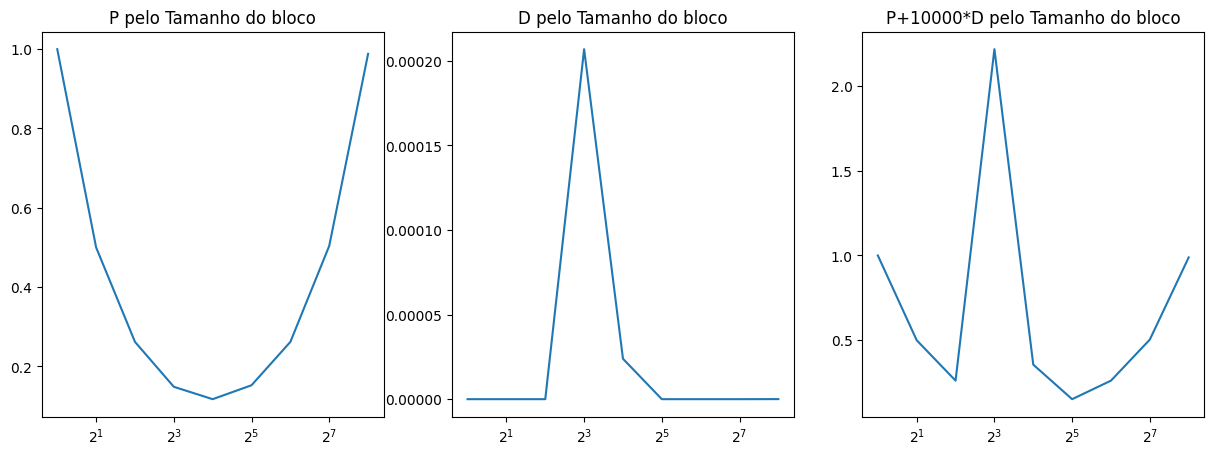

In [71]:
# Resposta do exercício 2b
# Use sua função para construir dois gráficos separados, de 𝑃 e 𝐷 em função de 𝐵=1,2,4,8,…,𝑁. 
# Dica: Use um eixo x logarítmico na base 2 para facilitar a visualização, 
# com o comando ax[i].set_xscale('log',base=2)
def plot_p_d_por_tamanho_bloco(x):
    Bs = [1,2,4,8,16,32,64,128,256]
    
#     Bs = [2,256]
    
    Ps = []
    Ds = []
    
    cur_p = 0.0
    cur_d = 0.0
    
    for b in Bs:
        lixo, cur_p, cur_d = CompDescompSegm(x,b)
        print(f'bloco={b} \tD={cur_d:.4} \tP={cur_p:.4} ')
        
        Ps.append(cur_p)
        Ds.append(cur_d)

        
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].set_title('P pelo Tamanho do bloco');
    ax[0].set_xscale('log',base=2)
    ax[0].plot(Bs, Ps, label='P')
    
    ax[1].set_title('D pelo Tamanho do bloco');
    ax[1].set_xscale('log',base=2)
    ax[1].plot(Bs, Ds, label='D pele Tamanho do bloco')
    
    ax[2].set_title('P+10000*D pelo Tamanho do bloco');
    ax[2].set_xscale('log',base=2)
    ax[2].plot(Bs, np.array(Ps)+(10000*np.array(Ds)), label='D pele Tamanho do bloco')

        
plot_p_d_por_tamanho_bloco(x)

In [24]:
left_alignment = "bloco=2"
center_alignment = "P=0.5"
right_alignment = "D=4.93e-32"
  
# printing out aligned text
print(f"{left_alignment : <10}{center_alignment : ^15}{right_alignment : >15}")

bloco=2        P=0.5          D=4.93e-32


**Comentários da questão 2b**

Na esquerda, estamos plotando a razão de compressão a cada tamanho de bloco.
Na direita, estamos plotando a distorção do sinal reconstruído a cada tamanho de blocos.

O formato do gráfico esquerdo em U, sugere que o valor central, quando B=2^4=16 seria uma boa escolha se levarmos em conta apenas a razão de compressão.


Se for para levar em consideração o impacto da distorção, o B=2^5=32 é a melhor escolha de tamanho de bloco que gera a menor distorção.